In [1]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from timeit import default_timer as timer
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-02-26 23:14:22.028157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740582862.043194   22176 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740582862.047370   22176 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 23:14:22.062490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Set GPU Allocation
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1740578317.588771   12239 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## START OF THE TRAINING PROCESS

In [3]:
# Define the base directory
# Rice Bran
base_dir_rb = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3'
#base_dir_rb = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 4'

# Define the subdirectories for each type
pure_rb_dir = os.path.join(base_dir_rb, 'Pure')
adulterated_rb_dir = os.path.join(base_dir_rb, 'Adulterated')

# Soybean Meal
base_dir_sbm = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 2'
#base_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1'
#base_dir_sbm = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 3'

# Define the subdirectories for each type
pure_sbm_dir = os.path.join(base_dir_sbm, 'Pure')
adulterated_sbm_dir = os.path.join(base_dir_sbm, 'Adulterated')

# Corn
base_dir_corn = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Training and Validation/Set 2'
#base_dir_corn = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Training and Validation/Set 3'

# Define the subdirectories for each type
pure_corn_dir = os.path.join(base_dir_corn, 'Pure')
adulterated_corn_dir = os.path.join(base_dir_corn, 'Adulterated')


# image_path = os.path.join(adulterated_rb_dir, 'Adulterated_original_image (13).jpg_4a486883-be2c-414c-9d5e-0545d28807d8.jpg')
# img = mpimg.imread(image_path)
# print(img.shape)
# plt.imshow(img)
# plt.show()


### Data Splitting

In [4]:
def split_data(base_dir):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='training',
        seed = 123,
        label_mode='binary',
        image_size=(400, 400),
        batch_size=32,
        shuffle=True
    )

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='validation',
        seed = 123,
        label_mode='binary',
        image_size=(400, 400),
        batch_size=32,
        shuffle=False
    )

    # class_names = train_ds.class_names
    # print(class_names)

    return [train_ds, validation_ds]

### Training Process With Different Types of CNN Architecture

In [5]:
def train_data(model_type, epoch, lr, train_ds, validation_ds, p):
    start = timer()

    # Custom CNN Model
    model = model_type
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=p,          # Number of epochs with no improvement to wait
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
    )

    model_history = model.fit(
        x=train_ds, 
        validation_data=validation_ds, 
        epochs=epoch,
        callbacks=[early_stopping]  # Add EarlyStopping callback
    )

    print('Total Time consumed for ' + str(model_history.epoch[-1] + 1) + ' --->', timer()-start) #Corrects epoch count

    return model_history

#### Base Directories of each ingredients

In [6]:
rb_data = split_data(base_dir_rb)
sbm_data = split_data(base_dir_sbm)
corn_data = split_data(base_dir_corn)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.


I0000 00:00:1740582894.828619   22176 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 4000 files belonging to 2 classes.
Using 800 files for validation.
Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.
Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


#### Custom CNN Model

In [ ]:
def CustomModel():
    custom_model = Sequential()

    # First Layer
    custom_model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(400, 400, 3)))
    custom_model.add(layers.BatchNormalization())  # Add Batch Normalization
    custom_model.add(layers.MaxPooling2D((2, 2)))

    # Second Layer
    custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    custom_model.add(layers.BatchNormalization())  # Add Batch Normalization
    custom_model.add(layers.MaxPooling2D((2, 2)))

    # Last Layer
    custom_model.add(layers.Flatten())
    custom_model.add(layers.Dropout(0.5))  # Add Dropout

    custom_model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 Regularization
    custom_model.add(layers.Dropout(0.5))  # Add Dropout

    custom_model.add(layers.Dense(1, activation='sigmoid'))

    #custom_model.summary()

    return custom_model

In [ ]:
# view model summary
cnn.CustomModel().summary()

# Create model for Rice Bran
custom_rb_model = cnn.CustomModel()

custom_rb_history = train_data(custom_rb_model, 15, 0.0001, rb_data[0], rb_data[1])



/home/cs_root/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 398, 398, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 197, 197, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 614656)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 614656)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    19,669,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,747,201 (75.33 MB)

 Trainable params: 19,746,817 (75.33 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15


I0000 00:00:1740572989.360327    2861 service.cc:148] XLA service 0x7f27bc00e0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740572989.360349    2861 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-26 20:29:49.421227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740572989.678224    2861 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-26 20:29:50.963544: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-26 20:29:50.963619: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out

#### Evaluate Model

In [ ]:
fig_one = plt.gcf()

# Model Accuracy
plt.plot(custom_rb_history.history['accuracy'])
plt.plot(custom_rb_history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# Model Loss
plt.plot(custom_rb_history.history['loss'])
plt.plot(custom_rb_history.history['val_loss'])
plt.axis(ymin=0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#### ResNet-50 Model

In [7]:
def ResNetModel(num_layers):
    #resnet_model = Sequential()
    
    pretrained_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(400, 400, 3),
        weights='imagenet',
    )

    for layer in pretrained_model.layers[:num_layers]:
        layer.trainable = False

    #pretrained_model.trainable = False  # Freeze ResNet layers initially

    # num_layers = len(pretrained_model.layers)
    # print(f"Total number of layers in ResNet50: {num_layers}")

    x = pretrained_model.output
    x = layers.GlobalAveragePooling2D()(x) #GAP Layer

    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) #L2 Regularization added, can be adjusted or removed
    x = layers.Dropout(0.3)(x)

    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) #L2 Regularization added, can be adjusted or removed
    # x = layers.Dropout(0.5)(x)

    predictions = layers.Dense(1, activation='sigmoid')(x) # 2 output classes

    resnet_model = keras.Model(inputs=pretrained_model.input, outputs=predictions)

    # Add the layers
    # resnet_model.add(pretrained_model)
    # resnet_model.add(layers.GlobalAveragePooling2D())
    
    # resnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    # resnet_model.add(layers.Dropout(0.3))
    # resnet_model.add(layers.BatchNormalization())

    # # resnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))) # Added Dense Layer
    # # resnet_model.add(layers.Dropout(0.5))
    # # resnet_model.add(layers.BatchNormalization())

    # # the last layer must specify how many number classes needed to evaluate
    # resnet_model.add(layers.Dense(1, activation = 'sigmoid'))

    #model.summary()

    return resnet_model

In [8]:
# view model summary
#ResNetModel(-8).summary()

# Rice Bran
resnet_rb_model = ResNetModel(-8)
resnet_rb_history = train_data(resnet_rb_model, 10, 0.00001, rb_data[0], rb_data[1], 2)

# Soybean Meal
resnet_sbm_model = ResNetModel(-8)
resnet_sbm_history = train_data(resnet_sbm_model, 10, 0.00001, sbm_data[0], sbm_data[1], 2)

# Corn
resnet_corn_model = ResNetModel(-8)
resnet_corn_history = train_data(resnet_corn_model, 10, 0.00001, corn_data[0], corn_data[1], 2)

# Fine-tuning (Unfreeze Top Layers)
# pretrained_model = resnet_model.layers[0] # Get the ResNet50 model

# # Unfreeze some top layers (experiment with the number)
# for layer in pretrained_model.layers[170:]:  # Unfreeze from layer n onwards (adjust)
#     layer.trainable = True

# # Important: Recompile the model after changing trainable status
# resnet_model.compile(optimizer=Adam(learning_rate=1e-5),  # Very low learning rate for fine-tuning
#                     loss='binary_crossentropy', 
#                     metrics=['accuracy'])

# resnet50_model_history = resnet_model.fit(x = train_ds, validation_data=validation_ds, epochs=3)
# print('Total Time consumed for ' + str(epoch) + ' epoch/s --->', timer()-start)

Epoch 1/10


I0000 00:00:1740583093.012273   22291 service.cc:148] XLA service 0xe8302c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740583093.012311   22291 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-26 23:18:13.284987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740583094.482965   22291 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740583111.430922   22291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.7093 - loss: 0.6966 - val_accuracy: 0.8975 - val_loss: 0.6135
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - accuracy: 0.9368 - loss: 0.3073 - val_accuracy: 0.9650 - val_loss: 0.4190
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - accuracy: 0.9644 - loss: 0.2427 - val_accuracy: 0.9875 - val_loss: 0.2732
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.9789 - loss: 0.2039 - val_accuracy: 0.9975 - val_loss: 0.1899
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.9857 - loss: 0.1831 - val_accuracy: 1.0000 - val_loss: 0.1514
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.9849 - loss: 0.1775 - val_accuracy: 1.0000 - val_loss: 0.1415
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.9950 - loss: 0.1580 - val_accuracy: 1.0000 - val_loss: 0.1355
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.9925 - loss: 0.1615 - val

#### Evaluate Model

In [ ]:
# 1. Get predictions (probabilities)
#train_predictions = resnet_model.predict(train_ds)
val_predictions = resnet_model.predict(validation_ds)

# 2. Convert probabilities to labels (0 or 1)
def get_true_labels(dataset):
    all_labels = []
    for x, y in dataset:  # Iterate through the dataset
        if isinstance(y, np.ndarray):  # Check if y is already a NumPy array
            all_labels.extend(y)
        else:
            all_labels.extend(np.array(y)) # Convert to numpy array if it's a list or tuple
    return np.array(all_labels)

#train_labels = get_true_labels(train_ds)
val_labels = get_true_labels(validation_ds)

train_predicted_labels = (train_predictions > 0.5).astype(int)  # Assuming binary classification
val_predicted_labels = (val_predictions > 0.5).astype(int)

# 3. Calculate and print metrics
def calculate_and_print_metrics(true_labels, predicted_labels, set_name):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=1)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"--- {set_name} Set Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    return accuracy, precision, recall, f1

train_accuracy, train_precision, train_recall, train_f1 = calculate_and_print_metrics(train_labels, train_predicted_labels, "Training")
val_accuracy, val_precision, val_recall, val_f1 = calculate_and_print_metrics(val_labels, val_predicted_labels, "Validation")


# Print the metrics (you can customize this part)
print("\n--- Overall Results ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")

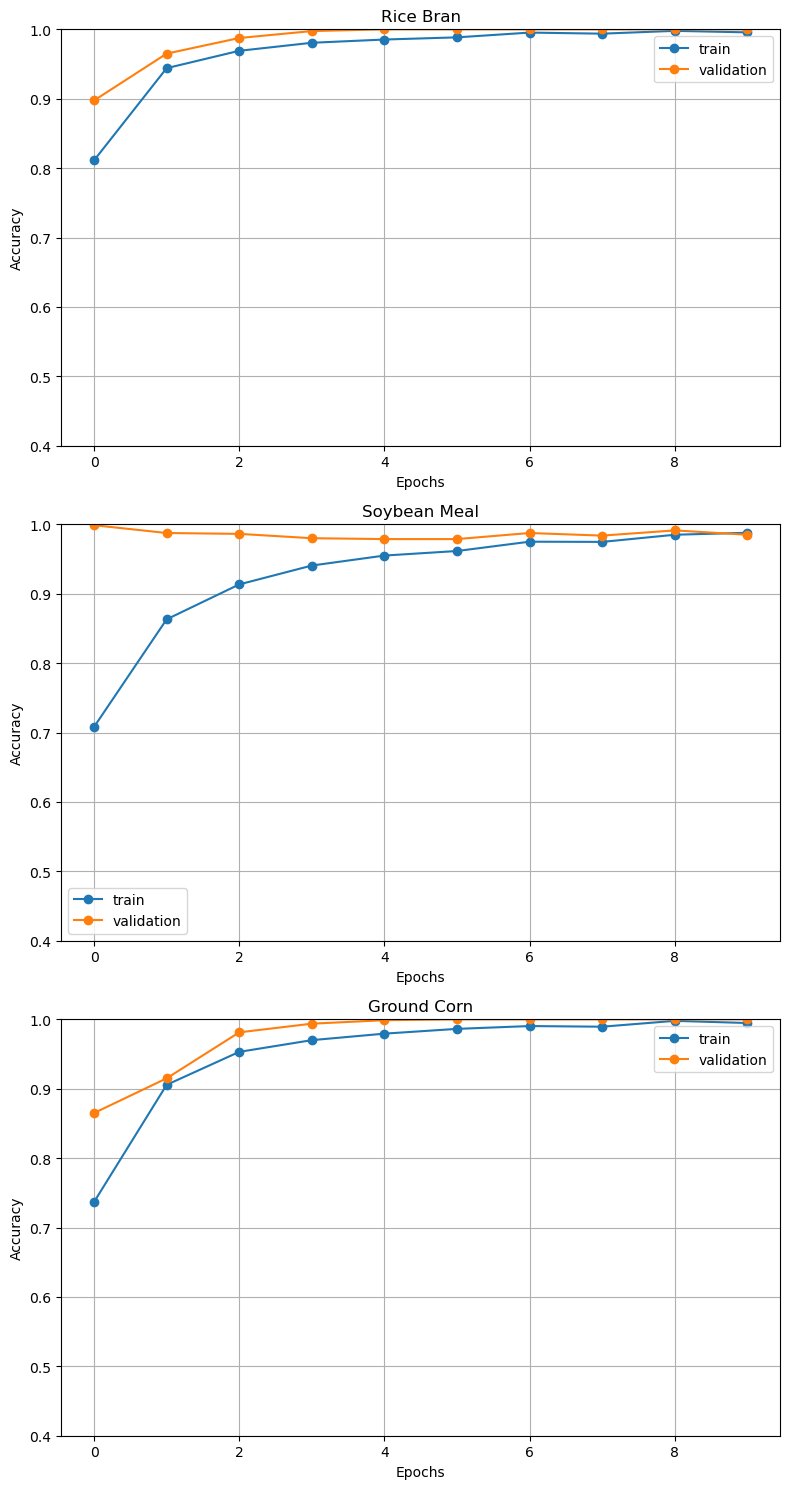

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(resnet_rb_history.history['accuracy'], marker='o', linestyle='-')
axes[0].plot(resnet_rb_history.history['val_accuracy'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)
axes[0].set_ylim(0.4, 1) # Set y-axis limits

# Soybean Meal Plot
axes[1].plot(resnet_sbm_history.history['accuracy'], marker='o', linestyle='-')
axes[1].plot(resnet_sbm_history.history['val_accuracy'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)
axes[1].set_ylim(0.4, 1) # Set y-axis limits

# Ground Corn Plot
axes[2].plot(resnet_corn_history.history['accuracy'], marker='o', linestyle='-')
axes[2].plot(resnet_corn_history.history['val_accuracy'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)
axes[2].set_ylim(0.4, 1) # Set y-axis limits

plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

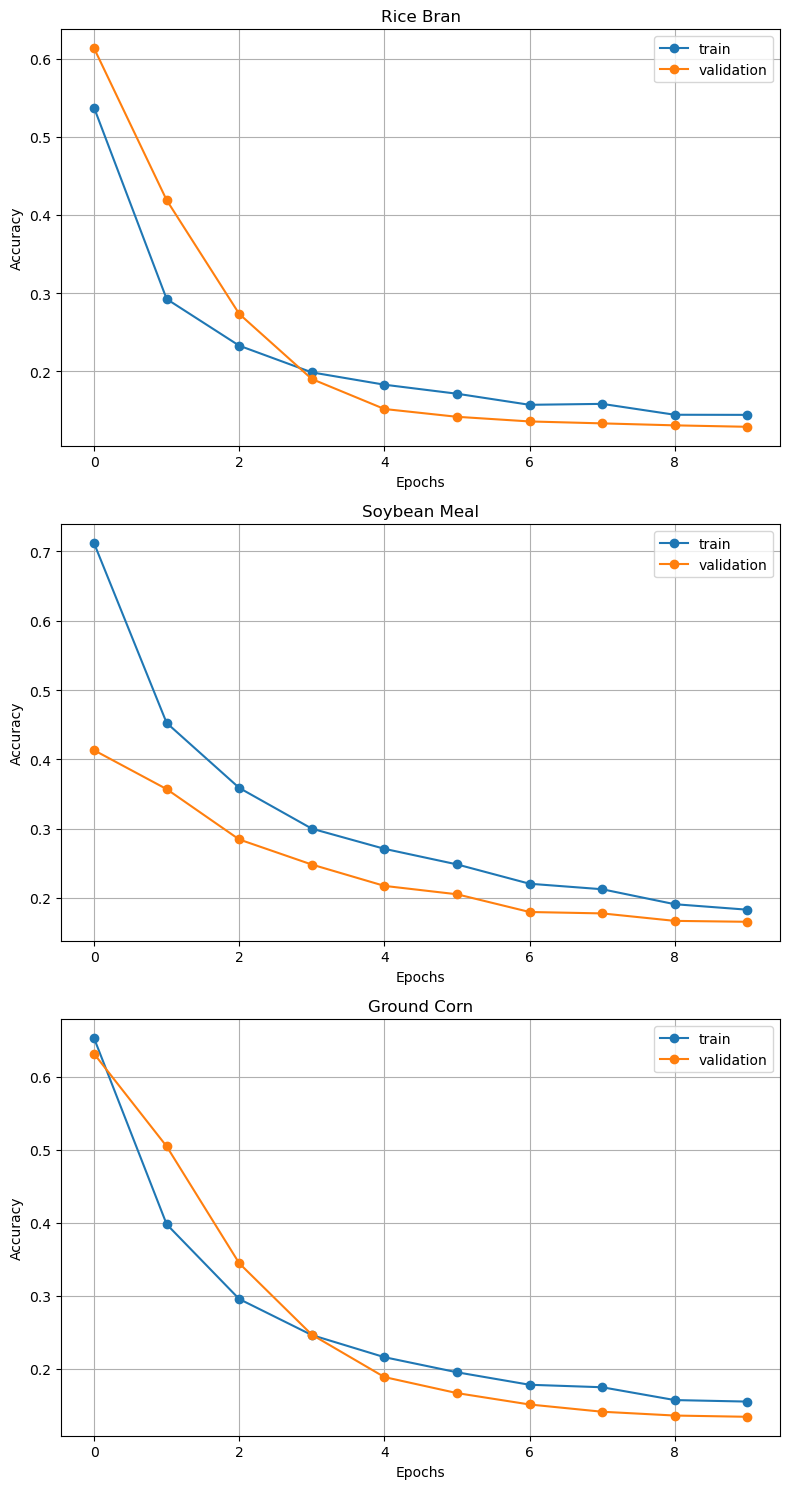

In [12]:
# Model Loss
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(resnet_rb_history.history['loss'], marker='o', linestyle='-')
axes[0].plot(resnet_rb_history.history['val_loss'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)

# Soybean Meal Plot
axes[1].plot(resnet_sbm_history.history['loss'], marker='o', linestyle='-')
axes[1].plot(resnet_sbm_history.history['val_loss'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)

# Ground Corn Plot
axes[2].plot(resnet_corn_history.history['loss'], marker='o', linestyle='-')
axes[2].plot(resnet_corn_history.history['val_loss'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)

plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

## TESTING THE MODEL

In [23]:
def test_set(test_dir):
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(400, 400),
        batch_size=32,
        label_mode='binary',
        shuffle=False
    )

    return test_ds

def evaluate_model(model, test_ds, feed_type):
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

    # Generate predictions
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    y_pred = (y_pred > 0.5).astype(int)  # For binary classification

    # Compute evaluation metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({feed_type})')
    plt.show()


In [21]:
# Testing Dataset Directory
# Rice Bran
test_dir_rb = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3')
#test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 2'
#test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 4'

# Soybean Meal
test_dir_sbm = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 2')
#test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 1'

# Corn
test_dir_corn = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Testing/Set 2')
#test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Testing/Set 1'



Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


### Evaluate Custom Model

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = custom_rb_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = custom_rb_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)  # For binary classification

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Evaluate ResNet Model

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 1.0000 - loss: 0.1283
Test Loss: 0.12896527349948883
Test Accuracy: 1.0
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      1.00      1.00       300
        Pure       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


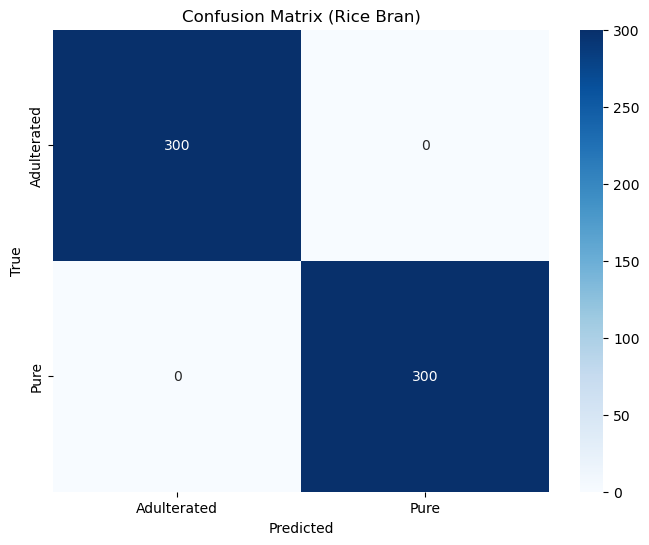

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.9971 - loss: 0.1535
Test Loss: 0.15115539729595184
Test Accuracy: 0.996666669845581
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      1.00      1.00       300
        Pure       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Precision: 0.9966666666666667
Recall: 0.9966666666666667
F1 Score: 0.9966666666666667


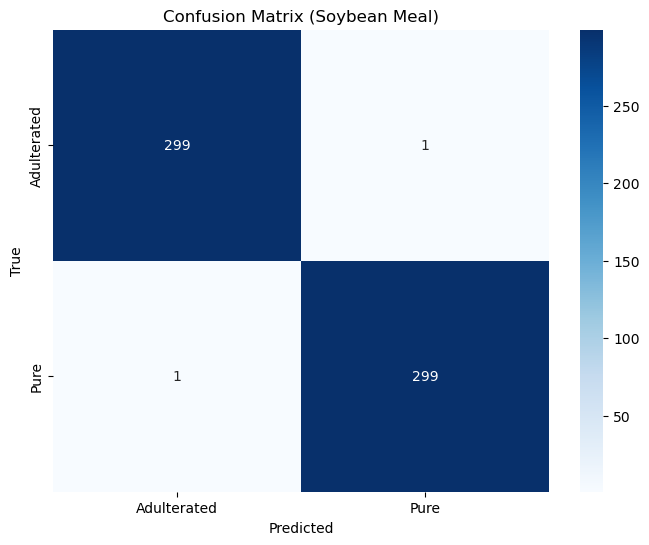

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 1.0000 - loss: 0.1277
Test Loss: 0.13458485901355743
Test Accuracy: 1.0
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      1.00      1.00       300
        Pure       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


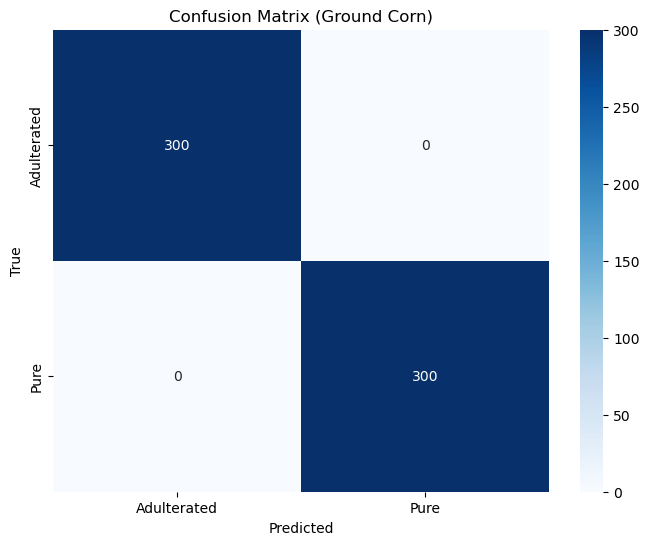

In [24]:
evaluate_model(resnet_rb_model, test_dir_rb, 'Rice Bran')
evaluate_model(resnet_sbm_model, test_dir_sbm, 'Soybean Meal')
evaluate_model(resnet_corn_model, test_dir_corn, 'Ground Corn')

### Save the Model

In [ ]:
# Save the entire model
# Rice Bran
#resnet_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_resnet_12.h5')
#custom_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_custom_7.h5')

# Soybean Meal
resnet_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Soybean Meal/set1_sbm_resnet_3.h5')

# Corn
#resnet_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Corn/set2_corn_resnet_2.h5')